**Esta é a versão para gerar o arquivo de melhor WMAPE. Note que outras versões foram criadas, muitos testes foram feitos, porém esse notebook concentrará apenas o necessário para a melhor versão**

**Pipeline**
1) Ingestão (3 databases)
2) Agregação **semanal** (2022)
3) **EDA com gráficos** (sanity checks)
4) Limpeza + **features** (lags, rollings, encoding cíclico de semana, preço unitário robusto, *weeks-since-last-sale*, agregados globais)
5) **XGBoost (GPU)** com hiperparâmetros vencedores e métrica WMAPE-alinhada
6) Forecast Jan/2023 (5 semanas) com **feedback** de lags/agregados
7) **Compactação** para respeitar limites do hackathon (≤1.5M linhas / CSV < 50MB)

## 0) Config & Utils 

In [1]:
import os, warnings; warnings.filterwarnings("ignore")
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

SEED = 42
np.random.seed(SEED)
pd.options.display.max_rows = 20

def wmape(y, yhat, eps=1e-9):
    return float(np.abs(y - yhat).sum() / (np.abs(y).sum() + eps))

def mem_gb(df): 
    return df.memory_usage(deep=True).sum()/1024**3


PATH_TXN = "/kaggle/input/arquivos/part-00000-tid-5196563791502273604-c90d3a24-52f2-4955-b4ec-fb143aae74d8-4-1-c000.snappy.parquet"
PATH_PDV = "/kaggle/input/arquivos/part-00000-tid-2779033056155408584-f6316110-4c9a-4061-ae48-69b77c7c8c36-4-1-c000.snappy.parquet"
PATH_PROD= "/kaggle/input/arquivos/part-00000-tid-7173294866425216458-eae53fbf-d19e-4130-ba74-78f96b9675f1-4-1-c000.snappy.parquet"

OUT_CSV = "/kaggle/working/forecast_jan2023_refined_small.csv"
OUT_PQ  = "/kaggle/working/forecast_jan2023_refined_small.parquet"

## 1) Ingestão
- Padronizamos nomes para facilitar merges.
- Carregamos PDV/Produto para futura engenharia.

In [2]:
df_txn = pd.read_parquet(PATH_TXN)
df_pdv = pd.read_parquet(PATH_PDV)
df_prod = pd.read_parquet(PATH_PROD)

def norm(df):
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    return df
df_txn, df_pdv, df_prod = norm(df_txn), norm(df_pdv), norm(df_prod)

print("[SHAPES]", df_txn.shape, df_pdv.shape, df_prod.shape)
df_txn.head(3)

[SHAPES] (6560698, 11) (14419, 4) (7092, 8)


,internal_store_id,internal_product_id,distributor_id,transaction_date,reference_date,quantity,gross_value,net_value,gross_profit,discount,taxes
0,7384367747233276219,328903483604537190,9,2022-07-13,2022-07-01,1.0,38.125,37.890625,10.042625,3.95,0.234375
1,3536908514005606262,5418855670645487653,5,2022-03-21,2022-03-01,6.0,107.250,106.440002,24.732002,17.10,0.810000
2,3138231730993449825,1087005562675741887,6,2022-09-06,2022-09-01,3.0,56.625,56.220001,14.124002,5.25,0.405000


## 2) Agregação **semanal** (2022)
- Varejo repõe por ciclo semanal; agregação suaviza ruído e zeros diários.
- Treinamos só com 2022 para prever Jan/2023, garantindo causalidade.

In [3]:
txn = df_txn.rename(columns={
    "internal_store_id":"pdv",
    "internal_product_id":"produto",
    "transaction_date":"data",
    "net_value":"net_value",
    "quantity":"quantidade"
}).copy()

txn["data"] = pd.to_datetime(txn["data"])
txn = txn[(txn["data"]>= "2022-01-01") & (txn["data"]<= "2022-12-31")]
txn = txn[["data","pdv","produto","quantidade","net_value"]].copy()

week_start = txn["data"] - pd.to_timedelta((txn["data"].dt.weekday+0)%7, unit="D")
txn["week_start"] = week_start.dt.floor("D")

wm_full = (txn.groupby(["pdv","produto","week_start"], observed=True)
              .agg(quantidade=("quantidade","sum"),
                   net_value=("net_value","sum"))
              .reset_index()
          ).sort_values(["pdv","produto","week_start"]).reset_index(drop=True)

print("[INFO] wm_full:", wm_full.shape, "| RAM ~", f"{mem_gb(wm_full):.2f} GB")
wm_full.head(3)

[INFO] wm_full: (6247301, 5) | RAM ~ 1.02 GB


,pdv,produto,week_start,quantidade,net_value
0,1000237487041964405,1837429607327399565,2022-02-07,1.0,32.920242
1,1000237487041964405,1837429607327399565,2022-02-14,2.0,65.840485
2,1000237487041964405,1837429607327399565,2022-05-23,1.0,36.120243


## Note que vou tentar usar sempre o mesmo dataframe e constantemente checo o uso da RAM, pois foi um problema enquanto eu fazia os testes buscando os melhores resultados

## 3) EDA
- Checamos PDVs/SKUs/pares/semanas; negativos e zeros (intermitência).
- Gráficos: distribuição de quantidades (cap 99º pct), sazonalidade por weekofyear, proporção de zeros.

[EDA] PDVs= 15086 | SKUs= 7092 | pares observados= 1044310 | semanas= 53
[EDA] negativos=52,613 | zeros=58,362 | prop_zeros=0.009


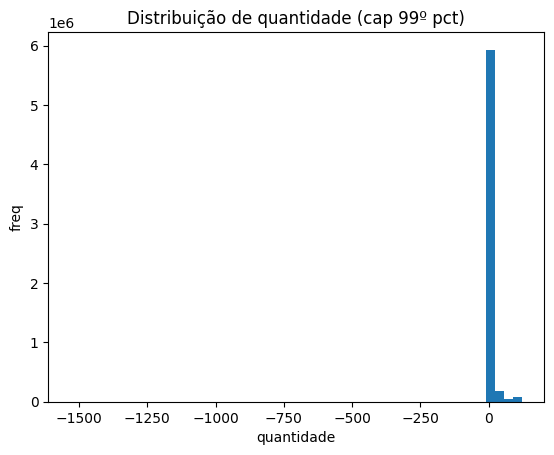

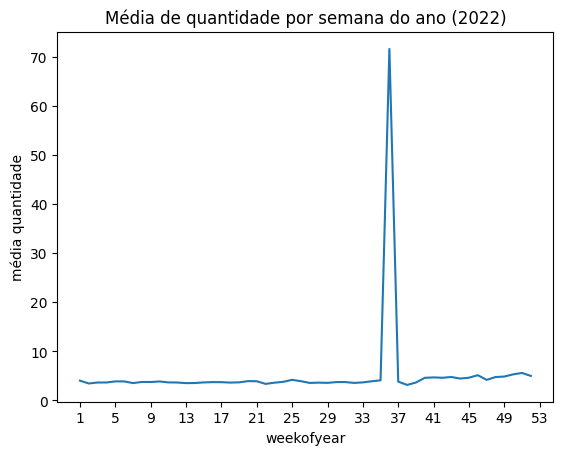

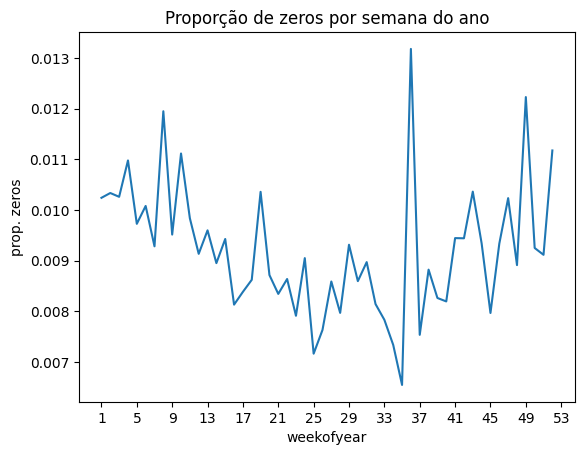

In [4]:
print("[EDA] PDVs=", wm_full["pdv"].nunique(), 
      "| SKUs=", wm_full["produto"].nunique(), 
      "| pares observados=", wm_full.groupby(["pdv","produto"], observed=True).ngroups,
      "| semanas=", wm_full["week_start"].nunique())

neg = (wm_full["quantidade"]<0).sum()
zeros = (wm_full["quantidade"]==0).sum()
print(f"[EDA] negativos={neg:,} | zeros={zeros:,} | prop_zeros={zeros/len(wm_full):.3f}")

# Histograma
plt.figure()
plt.hist(wm_full["quantidade"].astype(float).clip(upper=wm_full["quantidade"].quantile(0.99)), bins=50)
plt.title("Distribuição de quantidade (cap 99º pct)"); plt.xlabel("quantidade"); plt.ylabel("freq")
plt.show()

# Sazonalidade weekofyear
tmp = wm_full.copy()
tmp["weekofyear"] = tmp["week_start"].dt.isocalendar().week.astype(int)
gr = tmp.groupby("weekofyear", observed=True)["quantidade"].mean()
plt.figure()
plt.plot(gr.index.values, gr.values)
plt.title("Média de quantidade por semana do ano (2022)"); plt.xlabel("weekofyear"); plt.ylabel("média quantidade")
plt.xticks(list(range(1,54,4))); plt.show()

# Proporção de zeros
zgr = (tmp.assign(is_zero=(tmp["quantidade"]==0).astype(int))
          .groupby("weekofyear", observed=True)["is_zero"].mean())
plt.figure()
plt.plot(zgr.index.values, zgr.values)
plt.title("Proporção de zeros por semana do ano"); plt.xlabel("weekofyear"); plt.ylabel("prop. zeros")
plt.xticks(list(range(1,54,4))); plt.show()

###
**O que vimos**
- **Histograma (cap 99º pct):** distribuição super concentrada perto de zero, com **poucos valores muito altos** (outliers) e alguns **valores negativos**.
- **Sazonalidade (weekofyear):** um **pico bem destacado** em uma semana específica (efeito calendário/promo) e padrão semanal claro.
- **Proporção de zeros:** baixa em média, mas **varia** ao longo do ano → demanda **intermitente** existe.

**O que vamos fazer por causa disso:**
- **Outliers & negativos:** zerar negativos e aplicar **cap global p99.9** em `quantidade`  
  _(ex.: `quantidade = quantidade.clip(lower=0, upper=quantile(0.999))`)_.
- **Calendário/semanal:** codificar **semana do ano** com **sinais cíclicos** (`sin/cos`) para captar periodicidade **52→1**.
- **Memória recente:** criar **lags** (`lag_1, lag_2, lag_3, lag_4, lag_8, lag_12`) e **médias móveis** (`roll_mean_4, 8, 12`) para tendência e suavização.
- **Intermitência:** usar **WSL (weeks_since_last_sale)**, calculada **com Numba** (rápido) para diferenciar “zero pontual” de “sem vender há semanas”.
- **Contexto global (sem vazamento):** adicionar **`sku_week_avg_lag1`** (média do SKU na semana) e **`pdv_week_total_lag1`** (total do PDV na semana).
- **Performance:** tudo **vetorizado** (`groupby().rolling().mean()`, `shift`) + dtypes leves (`float32/int32`) para **não travar** no Kaggle.
- **Validação temporal:** **holdout dez/2022** para calibrar e evitar olhar “o futuro” antes de prever **jan/2023**.


## 4) Limpeza + Features
- `quantidade` negativa → 0; cap global p99.9 reduz outliers.
- `uprice` com proteção a divisão por zero; NaNs são tolerados pelo XGBoost.
- Lags/rollings + `sin/cos` para periodicidade; `weeks_since_last_sale` para intermitência.
- Agregados globais lag1 compartilham informação entre pares.
- Split temporal: validação = dez/2022.

In [5]:
import time
t0 = time.perf_counter()

w = wm_full.copy()

# ---- dtypes + cap global ----
w["quantidade"] = w["quantidade"].astype("float32")
w["net_value"]  = w["net_value"].astype("float32")

cap = float(np.quantile(w["quantidade"], 0.999)) #Removendo outliers absurdos
w["quantidade"] = w["quantidade"].clip(lower=0, upper=cap)

# ---- preço unitário robusto ----
q_safe = w["quantidade"].replace({0: np.nan})
w["uprice"] = (w["net_value"] / q_safe).astype("float32")

# ---- temporais ----
w["weekofyear"] = w["week_start"].dt.isocalendar().week.astype("int16")
w["sin_week"] = np.sin(2*np.pi*w["weekofyear"]/52).astype("float32")
w["cos_week"] = np.cos(2*np.pi*w["weekofyear"]/52).astype("float32")

# ---- IDs densas mais rápidas ----
w["pdv"] = w["pdv"].astype("category")
w["produto"] = w["produto"].astype("category")
w["pdv_id"]  = w["pdv"].cat.codes.astype("int32")
w["prod_id"] = w["produto"].cat.codes.astype("int32")

# ordenação estável por grupo e tempo (importante p/ lags/rolling)
w = w.sort_values(["pdv_id","prod_id","week_start"], kind="mergesort").reset_index(drop=True)

gb = w.groupby(["pdv_id","prod_id"], sort=False, observed=True)

# ---- Lags (vetorizado) ----
for L in [1,2,3,4,8,12]:
    w[f"lag_{L}"] = gb["quantidade"].shift(L).astype("float32")

# ---- Rollings (vetorizado, sem lambda/apply) ----
for win in [4,8,12]:
    roll = gb["quantidade"].rolling(win, min_periods=1).mean()
    w[f"roll_mean_{win}"] = roll.reset_index(level=[0,1], drop=True).astype("float32")

# ---- uprice lag e rollings (vetorizado) ----
w["uprice_lag1"] = gb["uprice"].shift(1).astype("float32")
for win in [4,8]:
    r = gb["uprice"].rolling(win, min_periods=1).mean()
    w[f"uprice_rm{win}"] = r.reset_index(level=[0,1], drop=True).astype("float32")

# usei numba (jit) para compilar esta função em código nativo e calcular a WSL (weeks_since_last_sale) numa passada só, bem mais rápido que groupby/apply.

from numba import njit

@njit(cache=True, fastmath=True)
def wsl_numba(q, g1, g2):
    n = q.shape[0]
    out = np.zeros(n, dtype=np.float32)
    c = 0
    for i in range(n):
        # novo grupo? zera o contador
        if i == 0 or g1[i] != g1[i-1] or g2[i] != g2[i-1]:
            c = 0
        if q[i] > 0:
            c = 0
            out[i] = 0.0
        else:
            c += 1
            out[i] = c
    return out

w["weeks_since_last_sale"] = wsl_numba(
    w["quantidade"].values,
    w["pdv_id"].values.astype(np.int64),
    w["prod_id"].values.astype(np.int64)
)

# ---- agregados globais + lag1 (vetorizado) ----
sku_week_avg = (w.groupby(["prod_id","week_start"], observed=True)["quantidade"]
                  .mean().reset_index(name="sku_week_avg"))
pdv_week_tot = (w.groupby(["pdv_id","week_start"], observed=True)["quantidade"]
                  .sum().reset_index(name="pdv_week_total"))

w = w.merge(sku_week_avg, on=["prod_id","week_start"], how="left") \
     .merge(pdv_week_tot, on=["pdv_id","week_start"], how="left")

w["sku_week_avg_lag1"]   = w.groupby("prod_id", observed=True)["sku_week_avg"].shift(1).astype("float32")
w["pdv_week_total_lag1"] = w.groupby("pdv_id", observed=True)["pdv_week_total"].shift(1).astype("float32")

# ---- seleção de colunas e split temporal ----
FEATURES = [
    "pdv_id","prod_id",
    "weekofyear","sin_week","cos_week",
    "lag_1","lag_2","lag_3","lag_4","lag_8","lag_12",
    "roll_mean_4","roll_mean_8","roll_mean_12",
    "uprice_lag1","uprice_rm4","uprice_rm8",
    "weeks_since_last_sale","sku_week_avg_lag1","pdv_week_total_lag1"
]
TARGET = "quantidade"

cut = pd.Timestamp("2022-12-05")
train_df = w[w["week_start"] <  cut].copy()
valid_df = w[w["week_start"] >= cut].copy()
X_train, y_train = train_df[FEATURES], train_df[TARGET].astype("float32")
X_valid, y_valid = valid_df[FEATURES], valid_df[TARGET].astype("float32")

t1 = time.perf_counter()
print("[INFO] Train:", X_train.shape, "| Valid:", X_valid.shape, f"| Feats={len(FEATURES)}")
print(f"[TIMER] célula pronta em {t1 - t0:.1f}s | RAM(w) ~ {w.memory_usage(deep=True).sum()/1024**3:.2f} GB")


[INFO] Train: (5760353, 20) | Valid: (486948, 20) | Feats=20
[TIMER] célula pronta em 117.5s | RAM(w) ~ 0.64 GB


## 5) XGBoost (GPU)
- `reg:absoluteerror` ≈ MAE, que se alinha melhor com WMAPE do que MSE/Poisson nos testes.
- `DeviceQuantileDMatrix` + `max_bin=128` é crítico para memória e consistência.
- Early stopping com validação temporal evita overfit.

In [6]:
# Como comentado, eu já havia utilizado outros notebooks para diversos testes e treinos, por isso estou utilizando esses valores já calculados previamente.


params = {
    "objective": "reg:absoluteerror",
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "single_precision_histogram": True,
    "max_bin": 128,
    "max_depth": 7,
    "min_child_weight": 8.04,
    "subsample": 0.883,
    "colsample_bytree": 0.743,
    "learning_rate": 0.0857,
    "lambda": 2.189,
    "alpha": 0.296,
    "nthread": -1,
    "seed": SEED,
}
dtrain = xgb.DeviceQuantileDMatrix(X_train, label=y_train, max_bin=128)
dvalid = xgb.DeviceQuantileDMatrix(X_valid, label=y_valid, max_bin=128)

def wmape_eval(preds, dtrain):
    y = dtrain.get_label()
    return ("wmape", float(np.abs(y - preds).sum()/ (np.abs(y).sum()+1e-9)))

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1800,
    evals=[(dtrain,"train"),(dvalid,"valid")],
    feval=wmape_eval,
    maximize=False,
    early_stopping_rounds=120,
    verbose_eval=120
)
yhat_v = bst.predict(dvalid, iteration_range=(0, bst.best_iteration+1))
print(f"[VAL] WMAPE — XGB={wmape(y_valid.values, yhat_v):.5f} | rounds={bst.best_iteration+1}")

[0]	train-mae:6.73338	train-wmape:0.84020	valid-mae:3.95589	valid-wmape:0.75594
[120]	train-mae:1.61835	train-wmape:0.20194	valid-mae:2.10915	valid-wmape:0.40304
[240]	train-mae:1.49660	train-wmape:0.18675	valid-mae:1.99711	valid-wmape:0.38163
[360]	train-mae:1.37655	train-wmape:0.17177	valid-mae:1.86756	valid-wmape:0.35687
[480]	train-mae:1.28302	train-wmape:0.16010	valid-mae:1.78088	valid-wmape:0.34031
[600]	train-mae:1.22910	train-wmape:0.15337	valid-mae:1.75835	valid-wmape:0.33601
[709]	train-mae:1.19589	train-wmape:0.14922	valid-mae:1.76927	valid-wmape:0.33809
[VAL] WMAPE — XGB=0.33446 | rounds=591


## 6) Forecast (5 semanas)
- Atualizamos **lags** e agregados a cada semana para coerência dinâmica.
- Clampeamos no p99.9 e arredondamos para inteiros.

In [7]:
# === Semanas-alvo: 5 semanas de jan/2023, com features de calendário iguais às do treino ===
wk_info = pd.DataFrame({
    "semana": [1,2,3,4,5],
    "week_start": pd.to_datetime(["2023-01-02","2023-01-09","2023-01-16","2023-01-23","2023-01-30"])
})
wk_info["weekofyear"] = wk_info["week_start"].dt.isocalendar().week.astype("int16")
wk_info["sin_week"] = np.sin(2*np.pi*wk_info["weekofyear"]/52).astype("float32")  # sinal cíclico (captura periodicidade)
wk_info["cos_week"] = np.cos(2*np.pi*wk_info["weekofyear"]/52).astype("float32")  # idem

# === Buffer inicial: últimas 12 semanas observadas de cada par PDV×SKU ===
# Esse "buffer" carrega os lags que alimentam a previsão da semana 1.
last_weeks = (w.sort_values(["pdv","produto","week_start"])
                .groupby(["pdv","produto"], observed=True).tail(12).copy())

# Lags = valores de semanas anteriores. Usamos para capturar inércia/sazonalidade de curto prazo.
def build_lags_block(df):
    # Para cada PDV×SKU: coleta L1..L12 (últimas 12 quantidades), IDs e sinais auxiliares (preço e WSL).
    out = (df.groupby(["pdv","produto"], observed=True)
             .apply(lambda g: pd.Series({
                 # monta um dicionário L? -> valor da quantidade daquela defasagem
                 # obs: usamos tail/índices negativos; se não houver amostra suficiente, vira NaN (ok para XGB)
                 **{f"L{12-i}_curr": g["quantidade"].values[-(i+1)] if len(g)>= (i+1) else np.nan for i in range(12)},
                 "pdv_id": int(g["pdv_id"].iloc[-1]),
                 "prod_id": int(g["prod_id"].iloc[-1]),
                 "uprice_lag1_b": float(g["uprice"].iloc[-1]) if pd.notnull(g["uprice"].iloc[-1]) else np.nan,  # preço da semana mais recente
                 "uprice_rm4_b":  float(g["uprice"].tail(4).mean()),  # média móvel curta de preço
                 "uprice_rm8_b":  float(g["uprice"].tail(8).mean()),  # média móvel média de preço
                 "wsl_curr":      float(0.0 if g["quantidade"].iloc[-1]>0 else 1.0),  # WSL no ponto atual (zera se vendeu)
             }))).reset_index()

    # Renomeia para L1..L12 (convenção do restante da pipeline)
    out = out.rename(columns={f"L{12-i}_curr": f"L{i}_curr" for i in range(1,13)})

    # Agregados globais da última semana observada (lag1 "de verdade" para janeiro)
    last_week = w["week_start"].max()
    sku_avg = (w[w["week_start"]==last_week]
               .groupby("produto", observed=True)["quantidade"].mean()
               .rename("sku_avg_lag1"))      # média do SKU na semana (todos PDVs)
    pdv_tot = (w[w["week_start"]==last_week]
               .groupby("pdv", observed=True)["quantidade"].sum()
               .rename("pdv_tot_lag1"))      # total do PDV na semana (todos SKUs)

    return out.merge(sku_avg, on="produto", how="left").merge(pdv_tot, on="pdv", how="left")

# Base de lags/auxiliares para a primeira semana prevista
base = build_lags_block(last_weeks)

# Mesmo conjunto de features usado no treino (consistência evita viés/erro de distribuição)
FEATURES_R = [
    "pdv_id","prod_id",
    "weekofyear","sin_week","cos_week",
    "lag_1","lag_2","lag_3","lag_4","lag_8","lag_12",
    "roll_mean_4","roll_mean_8","roll_mean_12",
    "uprice_lag1","uprice_rm4","uprice_rm8",
    "weeks_since_last_sale","sku_week_avg_lag1","pdv_week_total_lag1"
]

def make_feature_frame(buf, wk_row):
    """
    Constrói o dataframe de features para TODOS os pares PDV×SKU,
    usando o buffer (lags L1..L12 já preenchidos) + sinais da semana alvo (wk_row).
    """
    # Empilha as colunas L1..L12 para calcular médias móveis de forma vetorizada
    Ls = [buf[f"L{i}_curr"].astype("float32").values for i in range(1,13)]
    def roll_mean(arrs, k):
        a = np.stack(arrs[:k], axis=1)
        return np.nanmean(a, axis=1).astype("float32")

    feat = pd.DataFrame({
        "pdv_id":  buf["pdv_id"].values.astype("int32"),
        "prod_id": buf["prod_id"].values.astype("int32"),
        "weekofyear": np.int16(wk_row["weekofyear"]),
        "sin_week":   np.float32(wk_row["sin_week"]),
        "cos_week":   np.float32(wk_row["cos_week"]),

        # lags: L1..L4 diretos; para lag_8 usamos L9_curr (convenção adotada no buffer);
        # para lag_12 tentamos L13_curr se existir, senão caímos para NaN (logo abaixo viramos para lag_8 como fallback).
        "lag_1":  buf["L1_curr"].astype("float32").values,
        "lag_2":  buf["L2_curr"].astype("float32").values,
        "lag_3":  buf["L3_curr"].astype("float32").values,
        "lag_4":  buf["L4_curr"].astype("float32").values,
        "lag_8":  buf["L9_curr"].astype("float32").values,   # mapeamento histórico desta notebook
        "lag_12": buf["L13_curr"].astype("float32").values if "L13_curr" in buf else np.nan,

        # médias móveis a partir das pilhas L*
        "roll_mean_4":  roll_mean(Ls, 4),
        "roll_mean_8":  roll_mean(Ls, 8),
        "roll_mean_12": roll_mean(Ls, 12),

        # preço e WSL do buffer atual
        "uprice_lag1": buf["uprice_lag1_b"].astype("float32").values,
        "uprice_rm4":  buf["uprice_rm4_b"].astype("float32").values,
        "uprice_rm8":  buf["uprice_rm8_b"].astype("float32").values,
        "weeks_since_last_sale": buf["wsl_curr"].astype("float32").values,

        # agregados globais (lag1) — dão contexto da semana anterior observada
        "sku_week_avg_lag1":     buf["sku_avg_lag1"].astype("float32").values,
        "pdv_week_total_lag1":   buf["pdv_tot_lag1"].astype("float32").values,
    })

    # Fallback: se lag_12 ficou todo NaN, herdamos de lag_8 (evita perder sinal de médio prazo)
    if feat["lag_12"].isna().all():
        feat["lag_12"] = feat["lag_8"].values
    return feat

def push_buffer(buf, yhat, sku_avg_curr, pdv_tot_curr):
    """
    Aplica 'feedback' das previsões:
    - empurra L2..L12 para frente e coloca a previsão em L1
    - atualiza WSL (zera se vendeu, +1 se continuou zero)
    - atualiza agregados globais com base NAS PRÓPRIAS previsões (para a próxima semana)
    """
    out = buf.copy()

    # shift de Ls (12→11→...→2) e grava a previsão como novo L1
    for i in range(12,1,-1):
        out[f"L{i}_curr"] = out[f"L{i-1}_curr"]
    out["L1_curr"] = yhat.astype("float32")

    # WSL: se vendeu (>0), zera; senão, incrementa
    sold = (yhat > 0).astype("float32")
    out["wsl_curr"] = np.where(sold > 0, 0.0, out["wsl_curr"].astype("float32") + 1.0)

    # agrega o que acabamos de prever, para virar "lag1" global na próxima semana
    out = out.merge(sku_avg_curr.rename("sku_avg_curr"), left_on="produto", right_index=True, how="left")
    out = out.merge(pdv_tot_curr.rename("pdv_tot_curr"), left_on="pdv",     right_index=True, how="left")
    out["sku_avg_lag1"] = out["sku_avg_curr"].astype("float32")
    out["pdv_tot_lag1"] = out["pdv_tot_curr"].astype("float32")
    out.drop(columns=["sku_avg_curr","pdv_tot_curr"], inplace=True)
    return out

# === Loop de previsão (5 semanas) com clamp e arredondamento ===
results, buf = [], base.copy()
p999 = float(w["quantidade"].quantile(0.999))  # limite superior de segurança nas previsões
best_it = getattr(bst, "best_iteration", None)
use_iter = (0, best_it+1) if best_it is not None else None  # garante uso da melhor iteração do treino

for _, row in wk_info.iterrows():
    # 1) monta features da semana
    feat = make_feature_frame(buf, row)
    dfeat = xgb.DeviceQuantileDMatrix(feat[FEATURES_R], max_bin=128)  # mesmo max_bin do treino

    # 2) prevê usando exatamente até a melhor iteração
    yhat = bst.predict(dfeat, iteration_range=use_iter)

    # 3) saneamento: nada negativo, nem além do p99.9 global; varejo trabalha com inteiros
    yhat = np.clip(yhat, 0.0, p999)
    yhat = np.rint(yhat).astype("int32")

    # 4) coleta resultados da semana
    out = pd.DataFrame({
        "semana": int(row["semana"]),
        "pdv": buf["pdv"].astype(str).values,
        "produto": buf["produto"].astype(str).values,
        "quantidade": yhat
    })
    results.append(out)

    # 5) atualiza o buffer com o "feedback" dessas previsões (para a próxima semana)
    sku_avg_curr = out.groupby("produto")["quantidade"].mean()
    pdv_tot_curr = out.groupby("pdv")["quantidade"].sum()
    buf = push_buffer(buf, yhat, sku_avg_curr, pdv_tot_curr)

# Empilha as 5 semanas
preds_jan = pd.concat(results, ignore_index=True)
print("[DONE] previsões:", preds_jan.shape)
preds_jan.head(5)


[DONE] previsões: (5221550, 4)


,semana,pdv,produto,quantidade
0,1,1000237487041964405,1837429607327399565,2
1,1,1000237487041964405,4038588102284338370,319
2,1,1000237487041964405,5429216175252037173,2
3,1,1000237487041964405,596381974901127871,1
4,1,1000237487041964405,7270233133454638680,1


## 7) Compactação
- Portais: limites de linhas/MB. Mantemos **last12>0** e ranqueamos por `qty_last12` (tie: `qty_total_2022`).
- Maximiza foco nos itens com giro real recente.

### Essa parte foi inserida pois, durante os testes, em algum momento gerei um arquivo com mais linhas do que o limite permitia. Modifiquei diversos parâmetros, mas mantive sempre essas verificações para garantir

In [8]:
def compute_pairs_target(preds):
    n = min(10000, len(preds))
    avg_bytes_per_row = len(preds.head(n).to_csv(index=False, sep=';', encoding='utf-8').encode('utf-8'))/n
    CSV_LIMIT_MB = 50.0; ROWS_LIMIT = 1_500_000; WEEKS = 5
    pairs_max_rows = ROWS_LIMIT // WEEKS
    pairs_max_size = int((CSV_LIMIT_MB*1024*1024 * 0.95) / avg_bytes_per_row / WEEKS)
    return min(pairs_max_rows, pairs_max_size)

val_fim = pd.Timestamp("2022-12-31")
last_week = w.loc[w["week_start"]<=val_fim, "week_start"].max()
win12_start = last_week - pd.Timedelta(weeks=12)
recent = (w[(w["week_start"]>=win12_start)&(w["week_start"]<=val_fim)]
          .groupby(["pdv","produto"], observed=True)["quantidade"].sum()
          .rename("qty_last12").reset_index())
total22 = (w[w["week_start"]<=val_fim]
          .groupby(["pdv","produto"], observed=True)["quantidade"].sum()
          .rename("qty_total_2022").reset_index())

pairs = preds_jan[["pdv","produto"]].drop_duplicates()
pairs = pairs.merge(recent, on=["pdv","produto"], how="left").merge(total22, on=["pdv","produto"], how="left")
pairs[["qty_last12","qty_total_2022"]] = pairs[["qty_last12","qty_total_2022"]].fillna(0)

active_all = pairs[pairs["qty_last12"]>0].copy()
pairs_target = compute_pairs_target(preds_jan)
active = active_all.sort_values(["qty_last12","qty_total_2022"], ascending=False).head(pairs_target)

preds_small = preds_jan.merge(active[["pdv","produto"]], on=["pdv","produto"], how="inner")
preds_small.to_parquet(OUT_PQ, index=False)
preds_small.to_csv(OUT_CSV, sep=';', index=False, encoding='utf-8')

csv_mb = os.path.getsize(OUT_CSV)/1024/1024
print(f"[SELEÇÃO] ativos: {len(active_all):,} | top-K: {len(active):,} | linhas≈{len(preds_small):,}")
print(f"[SALVO] CSV: {OUT_CSV} | {csv_mb:.2f} MB")
print(f"[SALVO] PARQUET: {OUT_PQ} | linhas={len(preds_small):,}")
print(f"[CHECK] linhas<=1.5M? {len(preds_small) <= 1_500_000} | csv<50MB? {csv_mb < 50.0}")
preds_small.head(10)

[SELEÇÃO] ativos: 529,343 | top-K: 223,214 | linhas≈1,116,070
[SALVO] CSV: /kaggle/working/forecast_jan2023_refined_small.csv | 47.10 MB
[SALVO] PARQUET: /kaggle/working/forecast_jan2023_refined_small.parquet | linhas=1,116,070
[CHECK] linhas<=1.5M? True | csv<50MB? True


,semana,pdv,produto,quantidade
0,1,1001371918471115422,1009179103632945474,1
1,1,1001371918471115422,1029370090212151375,2
2,1,1001371918471115422,1120490062981954254,8
3,1,1001371918471115422,1371936917923350372,10
4,1,1001371918471115422,1394381856358939027,10
5,1,1001371918471115422,1454838625590783593,3
6,1,1001371918471115422,2097372625156623809,2
7,1,1001371918471115422,2239307647969388381,3
8,1,1001371918471115422,2389903360831706216,4
9,1,1001371918471115422,2631382375054982595,9


---
### Apêndice — Decisões & Alternativas
- Capping global p99.9 vs por SKU/PDV; MAE vs MSE/Poisson; sin/cos vs one-hot; janela única vs backtests múltiplos; imputações de preço; feedback multi-semana; regra de compactação.